<a href="https://colab.research.google.com/github/15108326/ANAE/blob/master/deep_running4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
cancer=load_breast_cancer()
x=cancer.data
y=cancer.target

#**04-5 로지스틱회귀를 위한 뉴런을 만듭니다.**
3장에서 훈련 데이터 세트 전체를 사용하여 모델을 훈련했습니다. 그러나 모델의 성능을 평가하지 않았고 따라서 모델이 맞는지 아닌지를 알수가 없습니다. 여기서는 모델의 성능을 평가하는 방법에 대해서 알아보도록 하겠습니다.

##모델의 성능 평가를 위한 훈련 세트와 테스트 세트 
훈련된 모델의 실전 성능을 일반화 성능(generalization performance)이라고 부릅니다. 그런데 모델에 학습시킨 훈련 데이터 세트로 다시 모델의 성능을 평가하면 그 모델은 당연히 좋은 성능이 나올 것입니다. 이런 성능 평가를 '과도하게 낙관적으로 일반화 성능을 추정한다'고 말합니다. 따라서 훈련 데이터 세트를 두 덩어리로 나누어 하나는 훈련에, 다른 하나는 테스트에 사용하면 됩니다.  

**그림 추가**

##훈련 세트와 테스트 세트로 나누기
 
* 훈련 데이트 세트를 나눌 때는 테스트 
세트보다 훈련 세트가 더 많아야 합니다.  
* 훈련 데이터 세트를 나눌 때는 양성, 음성 클래스가 훈련 세트와 테스트 세트에 고르게 분포하도록 만들어야 합니다.


만약 훈련 세트에 양성 클래스가 많이 몰리거나 테스트 세트에 음성 클래스가 너무 많이 몰리면 모델이 데이터에 있는 패턴을 올바르게 학습하지 못하거나 성능을 잘못 측정할 수도 있습니다.

**그림추가**

위 그림을 보면 위쪽의 경우에는 그대로 2대1로 나누어져 잘 나누어졌고 밑쪽의 경우에는 클래스 비율이 망가져 있습니다. 클래스의 비율이 망가지면 모델에 사용할 데이터가 올바르지 않으므로 결과도 좋지 않습니다.

###1. train_test_split() 함수로 훈련 데이터 세트 나누기
사이킷런의 train_test_split() 함수는 기본적으로 입력된 훈련 데이터 세트를 훈련 세트 75%,테스트 세트 25% 비율로 나눠줍니다.

In [0]:
from sklearn.model_selection import train_test_split # sklearn.model_selection 모듈에서 train_test_split()함수를 임포트

In [0]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=42)

* stratify는 훈련 데이터를 나눌 때 클래스 비율을 동일하게 만듭니다.
* test_size는 기본적인 훈련 데이터 세트를 나누는 비율을 조절하고 싶을 때 사용합니다. 여기서는 test_size에 0.2를 전달하여 입력된 데이터 세트의 20%를 테스트 세트로 나눴습니다.
* 무작위로 섞은 결과를 항상 일정하도록 하기 위해서 random_state에 난수 초깃값을 지정했습니다.

###2. 결과 확인하기
이제 훈련 데이터 세트가 잘 나누어졌는지 훈련 세트와 테스트 세트의 비율을 확인해 보겠습니다. shape속성을 이용해 확인해 보면 훈련 세트와 테스트 세트가 4:1의 비율로 잘 나누어진 것을 알 수 있습니다.

In [4]:
print(x_train.shape,x_test.shape)

(455, 30) (114, 30)


###3. unique() 함수로 훈련 세트의 타깃 확인하기
넘파이의 unique() 함수로 훈련 세트의 타깃안에 있는 클래스의 개수를 확인해 보면 전체 훈련 데이터 세트의 클래스 비율과 거의 비슷한 구성인것을 알 수 있습니다.

In [5]:
np.unique(y_train, return_counts=True) # y의 요소를 중복없이 알려주며 return_counts를 통해서 각각의 요소의 수를 알 수 있습니다.

(array([0, 1]), array([170, 285]))

##로지스틱 회귀 구현하기
준비된 훈련 세트를 바탕으로 로지스틱 회귀를 구현해 보겠습니다. 로지스틱 회귀를 정방향으로 데이터가 흘러가는 과정(정방향 계산)부터 가중치를 업데이트하기 위해 역방향으로 데이터가 흘러가는 과정(역방향 계산)까지 순서대로 구현해 보겠습니다.

In [0]:
class LogisticNeuron:
    
    def __init__(self):
        self.w = None
        self.b = None

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b  # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err    # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

보면 3장에서 구현했던 Neuron클래스와는 다소 차이점이 있습니다. 
* 입력 데이터의 특성이 많아 `__init__()` 메서드는 가중치와 절편을 미리 초기화 하지 않습니다. 나중에 입력 데이터를 보고 특성 개수에 맞게 결정합니다.
* forpass() 메서드를 보면 가중치와 입력 특성의 곱을 모두 더하기 위해 np.sum()함수를 사용한 것을 알 수 있습니다.

##훈련하는 메서드 구현하기
###1. fit() 메서드 구현하기
훈련을 수행하는 fit() 메서드를 구현해 보겠습니다. 기본 구조는 3장의 Neuron클래스와 같지만 활성화 함수가 추가되었고 역방향 계산에는 로지스틱 손실 함수의 도함수를 적용합니다.

In [0]:
def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1])      # 가중치를 초기화합니다.
    self.b = 0                        # 절편을 초기화합니다.
    for i in range(epochs):           # epochs만큼 반복합니다
        for x_i, y_i in zip(x, y):    # 모든 샘플에 대해 반복합니다 , zip을 이용해서 자료를 묶어줍니다.
            z = self.forpass(x_i)     # 정방향 계산
            a = self.activation(z)    # 활성화 함수 적용
            err = -(y_i - a)          # 오차 계산
            w_grad, b_grad = self.backprop(x_i, err) # 역방향 계산
            self.w -= w_grad          # 가중치 업데이트
            self.b -= b_grad          # 절편 업데이트

###2. activation() 메서드 구현하기
시그모이드 함수가 사용되어야 합니다. 시그모이드 함수는 넘파이의 np.exp() 함수를 사용하여 간단히 만들 수 있습니다.

In [0]:
def activation(self, z):
    a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
    return a

##예측하는 메서드 구현하기
3장에서는 forpass() 메서드를 사용하여 새로운 샘플에 대한 예측값을 계산했으나 여러개의 샘플을 한꺼번에 예측할 때는 여러 번 호출해야하는 번거로움이 있습니다. 또한 분류에서는 활성화 함수와 임계 함수도 적용해야 하므로 새롭게 predict() 메서드를 만들어보겠습니다.

###1. predict() 메서드 구현하기
predict() 메서드의 매개변수 값으로 입력값 x가 2차원 배열로 전달된다고 가정하고 구현하게습니다. 예측값은 입력값을 선형 함수, 활성화 함수, 임계 함수 순서로 통과시키면 구할 수 있습니다.

In [0]:
def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]    # 정방향 계산
    a = self.activation(np.array(z))        # 활성화 함수 적용
    return a > 0.5

여기서 z의 계산에서 파이썬의 리스트 내포 문법을 사용했습니다. 리스트 내포란 대괄호([]) 안에 for문을 삽입하여 새 리스트를 만드는 문법입니다. x의 행을 하나씩 꺼내어 forpass() 메서드에 적용하고 그 결과를 이용하여 새 리스트(z)로 만드는 것입니다. z는 곧바로 넘파이 배열로 바꾸어 activation() 메서드로 전달됩니다.

##구현 내용 한눈에 보기

In [0]:
class LogisticNeuron:
    
    def __init__(self):
        self.w = None
        self.b = None

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b  # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err    # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])      # 가중치를 초기화합니다.
        self.b = 0                        # 절편을 초기화합니다.
        for i in range(epochs):           # epochs만큼 반복합니다
            for x_i, y_i in zip(x, y):    # 모든 샘플에 대해 반복합니다
                z = self.forpass(x_i)     # 정방향 계산
                a = self.activation(z)    # 활성화 함수 적용
                err = -(y_i - a)          # 오차 계산
                w_grad, b_grad = self.backprop(x_i, err) # 역방향 계산
                self.w -= w_grad          # 가중치 업데이트
                self.b -= b_grad          # 절편 업데이트
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]    # 정방향 계산
        a = self.activation(np.array(z))        # 활성화 함수 적용
        return a > 0.5

##로지스틱 회귀 모델 훈련시키기
준비한 데이터 세트를 바탕으로 로지스틱 회귀 모델을 훈련하고 정확도를 측정하겠습니다.

###1.모델 훈련하기
클래스의 객체를 만들고 훈련 세트와 함께 fit() 메서드를 호출하면 됩니다.

In [11]:
neuron = LogisticNeuron()
neuron.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


##2. 테스트 세트 사용해 모델의 정확도 평가하기
훈련이 끝난 모델에 테스트 세트를 사용해 예측값을 넣고 예측한 값이 맞는지 비교합니다.

In [12]:
np.mean(neuron.predict(x_test) == y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


0.8245614035087719

predict() 메서드의 반환값은 True나 False로 채워진 (m,) 크기의 배열이고 y_test는 0 또는 1로 채워진 (m,)크기의 배열이므로 바로 비교할 수 있습니다.np.mean() 함수는 매개변수 값으로 전달한 비교문 결과의 평균을 계산합니다. 즉, 계산 결과 0.82는 올바르게 예측한 샘플의 비율이 됩니다. 이를 정확도(accuracy)라고 합니다.

#**04-6 로지스틱 회귀 뉴런으로 단일층 신경망을 만듭니다.**
## 일반적인 신경망의 모습을 알아봅니다.
일반적으로 신경망은 다음과 같이 표현합니다. 가장 왼쪽이 입력층(input layer), 가장 오른쪽이 출력층(output layer) 그리고 가운데 층들을 은닉층(hidden layer)이라고 부릅니다. 작은 원으로 표시된 활성화 함수는 각 층의 한 부분으로 간주합니다.

**그림 추가**

###단일층 신경망의 모습을 알아봅니다.
앞에서 배운 로지스틱 회귀는 은닉층이 없는 신경망이라고 볼 수 있습니다. 이런 입력층과 출력층만 가지는 신경망을 단일층 신경망이라고 부릅니다. 이거을 그림으로 나타내면 아래와 같습니다.

**그림 추가**

##단일층 신경망을 구현합니다.
여기서는 미리 구현한 LogisticNeuron 클래스에 몇 가지 유용한 기능을 추가하여 다시 구현해보겠습니다. 

##손실 함수의 결괏값을 조정해 저장 기능 추가하기
`__init__()` 메서드에 손실 함수의 결괏값을 저장할 리스트 self,losses를 만듭니다.그런 다음 샘플마다 손실 함수를 계산하고 그 결괏값을 모두 더한 다음 샘플 개수로 나눈 평균값을 self.losses 변수에 저장합니다. 그리고 self.activation() 메서드로 계산한 a는 np,log()의 계산을 위해 한 번 더 조정합니다. 왜냐하면 a가 0에 가까워지면 np.log() 함수의 값은 음의 무한대가 되고 a가 1에 가까워지면 np.log() 함수의 값은 0이 되기 떄문입니다. 손실값이 무한해지면 계산을 할 수 없으므로 a의 값이 $1\times 10^{-10}\sim 1-1\times 10^{-10}$ 사이가 되도록 np.clip() 함수로 조정해야 합니다. np.clip() 함수는 주어진 범위 밖의 값을 범위 양 끝의 값으로 잘라 냅니다.

In [0]:
def __init__(self):
    self.w = None
    self.b = None
    self.losses = []

def fit(self, x, y, epochs=100):
        for i in index:                      # 모든 샘플에 대해 반복합니다
            z = self.forpass(x[i])             # 정방향 계산
            a = self.activation(z)             # 활성화 함수 적용
            err = -(y[i] - a)                  # 오차 계산
            w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
            self.w -= w_grad                   # 가중치 업데이트
            self.b -= b_grad                   # 절편 업데이트
            # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
            a = np.clip(a, 1e-10, 1-1e-10)
            loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a)) # 에포크마다 평균 손실을 저장합니다
        
        self.losses.append(loss/len(y))

##여러 가지 경사 하강법에 대해 알아봅니다.
지금까지 사용한 경사 하강법은 샘플 데이터 1개에 대한 그레디언트를 계산했습니다. 이를 확률적 경사 하강법(stochastic gradient descent)이라고 부릅니다.

**그림 추가**

또한 확률적 경사 하강법 외에 전체 훈련 세트를 사용하여 한 번에 그레디언트를 계산하는 방식인 배치 경사 하강법(batch gradient descent)과 배치(batch) 크기를 작게 하여(훈련 세트를 여러 번 나누어) 처리하는 방식인 미니 배치 경사 하강법(mini-batch gradient descent)이 있습니다.

**그림 추가**

**그림 추가**

확률적 경사 하강법은 샘플 데이터 1개마다 그레디언트를 계산하여 가중치를 업데이트하므로 계산 비용은 적은 대신 가중치가 최적값에 수렴하는 과정이 불안정합니다. 반면에 배치 경사 하강법은 전체 훈련 데이터 세트를 사용하여 한 번에 그레디언트를 계산하므로 가중치가 최적값에 수렴하는 과정은 안정적이지만 그만큼 계산 비용이 많이 듭니다. 이 둘의 장점을 절충한 것이 미니 배치 경사 하강법입니다. 다음은 확률적 경사 하강법, 배치 경사 하강법이 최적의 가중치(w1,w2)에 수렴하는 과정을 나타낸 그래프입니다. 미니 배치 경사 하강법은 확률적 경사 하강법보다는 매끄럽고 배치 경사 하강법보다는 덜 매끄러운 그래프가 그려집니다.

**그림 추가**

###매 에포크마다 훈련 세트의 샘플 순서를 섞어 사용하기
훈련 세트의 샘플 순서를 섞으면 가중치 최적값의 탐색 과정이 다양해져 가중치 최적값을 제대로 찾을 수 있습니다. 다음 그림은 첫 번째 에포크에서 사용한 샘플의 순서와 두 번째 에포크에서 사용한 샘플의 순서를 나타낸 것입니다.

**그림 추가**

**그림 추가**

훈련 세트의 샘플 순서를 섞는 전형적인 방법은 넘파이 배열의 인덱스를 섞은 수 인덱스 순서대로 샘플을 뽑는 것입니다. 이 방법이 훈련 세트 자체를 섞는 것보다 효율적이고 빠릅니다. np,random.permutation() 함수를 사용하면 이 방법을 구현할 수 있습니다.

In [0]:
def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
    self.b = 0                                 # 절편을 초기화합니다.
    for i in range(epochs):                    # epochs만큼 반복합니다
        loss = 0
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다
        for i in indexes:                      # 모든 샘플에 대해 반복합니다
            z = self.forpass(x[i])             # 정방향 계산
            a = self.activation(z)             # 활성화 함수 적용
            err = -(y[i] - a)                  # 오차 계산
            w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
            self.w -= w_grad                   # 가중치 업데이트
            self.b -= b_grad                   # 절편 업데이트
            a = np.clip(a, 1e-10, 1-1e-10)  # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
            loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))  # 에포크마다 평균 손실을 저장합니다
        self.losses.append(loss/len(y))

###score() 메서드 추가하기
정확도를 계산해 주는 score() 메서드를 추가하고 predict() 메서드도 수정하겠습니다. score() 메서드에는 정확도를 계산할 때 사용했던 np.mean() 함수를 사용합니다.

In [0]:
def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
    return np.array(z) > 0                   # 스텝 함수 적용
    
def score(self, x, y):
    return np.mean(self.predict(x) == y)

시그모이드 함수의 출력값은 0~1 사이의 확률값이고 양성 클래스를 판단하는 기준은 0.5이상입니다. 그런데 z가 0보다 크면 시그모이드 함수의 출력값은 0.5보다 크고 z가 0보다 작으면 시그모이드 함수의 출력값은 0.5보다 작습니다. 그래서 predict() 메서드에는굳이 시그모이드 함수를 사용하지 않아도 됩니다. 그래서 predict() 메서드에는 로지스틱 함수를 적용하지 않고 z값의 크기만 비교하여 결과를 반환했습니다.

In [0]:
class SingleLayer:
    
    def __init__(self):
        self.w = None
        self.b = None
        self.losses = []

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b  # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err    # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다
            loss = 0
            indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                self.w -= w_grad                   # 가중치 업데이트
                self.b -= b_grad                   # 절편 업데이트
                a = np.clip(a, 1e-10, 1-1e-10)     # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))  # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y))
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) > 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

##단일층 신경망 훈련하기
###1. 단일층 신경망 훈련하고 정확도 출력하기
클래스의 객체를 만들고 훈련 세트로 신경망을 훈련한 다음 score() 메서드로 정확도를 출력해겠습니다.

In [18]:
layer = SingleLayer()
layer.fit(x_train, y_train)
layer.score(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


0.9473684210526315

##2. 손실 함수 누적값 확인하기
성능이 에포크마다 훈련 세트를 무작위로 섞어 손실함수의 값을 줄였기 때문에 좋아졌습니다. 이를 확인하기 위해서 그래프를 그려보겠습니다.

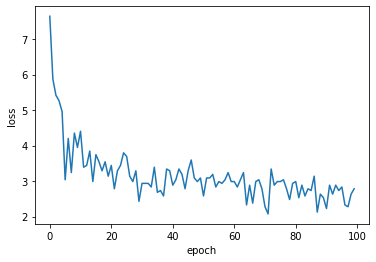

In [19]:
plt.plot(layer.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

로지스틱 손실 함수의 값이 에포크가 진행됨에 따라 감소하고 있음을 확인할 수 있습니다. 이로써 가장 기초적인 신경망 알고리즘이 구현되었습니다.

#**04-7 사이킷런으로 로지스틱 회귀를 수행합니다.**
사이킷런의 경사 하강법이 구현된 SGDClassifier클래스를 이용하여 로지스틱 회귀 문제를 간단히 해결해 보겠습니다.

##사이킷런으로 경사 하강법 적용하기
###1. 로지스틱 손실 함수 지정하기
SGDClassifier 클래스에 로지스틱 회귀를 적용하려면 loss 매개변수에 손실 함수로 log를 지정합니다.

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
sgd = SGDClassifier(loss='log', max_iter=100, tol=1e-3, random_state=42)

max_iter를 통해 반복 횟수를 100으로 지정합니다. 반복할 때마다 로지스틱 손실 함수의 값이 tol에 지정한 값만큼 감소되지 않으면 반복이 중단되도록 설정합니다. 만약 tol의 값을 설정하지 않으면 max_iter의 값을 늘리라는 경고가 발생합니다. 이는 모델의 로지스틱 손실 함수의 값이 최적값으로 수렴할 정도로 충분한 반복 횟수를 입력했는지 사용자에게 알려주므로 유용합니다.

###2. 사이킷런으로 훈련하고 평가하기
사이킷런의 SGDClassifier 클래스에는 지금까지 우리가 직접 구현한 메서드가 이미 준비되어 있습니다.

In [22]:
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.8333333333333334

###3. 사이킷런으로 예측하기
예측을 위한 메서드도 구현되었습니다. 주의할 점은 사이킷런은 입력 데이터로 2차원 배열만 받아들입니다.즉, 샘플 하나를 주입하더라도 2차원 배열로 만들어야 합니다. 여기서는 배열의 슬라이싱을 사용해 테스트 세트에서 10개의 샘플만 뽑아 예측을 만들어 보겠습니다.

In [25]:
sgd.predict(x_test[0:10])

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])